In [8]:
import csv
import math

# Models

In [9]:
from dataclasses import dataclass
from typing import Optional
import random

import numpy as np


@dataclass
class Observation:
    features: np.ndarray
    values: np.ndarray


class Perceptron:
    def __init__(
        self,
        initial_weights: list,
        initial_bias: Optional[list] = None,
        eta: float = 0.1,
    ) -> None:
        self.weights = np.array(initial_weights)
        if initial_bias is not None:
            self.bias: Optional[np.ndarray] = np.array(initial_bias)
        else:
            self.bias = None
        self.eta = np.array(eta)

    def activity_value(self, input_vector: np.ndarray) -> np.ndarray:
        # row vector * column vector + bias
        return input_vector @ self.weights + (self.bias if self.bias is not None else 0)

    def activation_value(self, input_vector: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-self.activity_value(input_vector)))

    def compute_error(self, desired_output: np.ndarray) -> np.ndarray:
        self.error = desired_output - self.last_output
        return self.error

    def prev_delta(self) -> np.ndarray:
        delta = self.weights * self.delta.reshape(-1, self.weights.shape[1])
        return delta

    def compute_delta(self, error: np.ndarray) -> np.ndarray:
        self.delta: np.ndarray = (
            error.reshape(-1, self.weights.shape[1])
            * (1 - self.last_output)
            * self.last_output
        )
        return self.delta

    def feed_forward(self, input_vector: np.ndarray) -> np.ndarray:
        self.last_input = input_vector
        self.last_output = self.activation_value(input_vector)
        return self.last_output

    def back_prop(self, error: np.ndarray) -> np.ndarray:
        """returns the deltas to be used by the previous layer and updates model
        weights"""
        self.compute_delta(error)
        prev_delta = self.prev_delta()
        self.update_weights()

        return prev_delta

    def update_weights(self) -> None:
        self.weights = self.weights + self.eta * (self.delta * self.last_input.T)

        if self.bias is not None:
            self.bias = self.bias + self.eta * self.delta

    def __call__(self, input_vector: np.ndarray) -> float:
        return self.activation_value(input_vector)[0][0]


class Multilayer:
    def __init__(
        self, initial_weights: list, initial_bias: list, eta: float = 0.1
    ) -> None:
        self.layers = [
            Perceptron(weights, biases, eta)
            for weights, biases in zip(initial_weights, initial_bias)
        ]

    def activation_value(self, input_vector: np.ndarray) -> np.ndarray:
        data_in = input_vector
        for layer in self.layers:
            out = layer.activation_value(data_in)
            data_in = out.reshape(1, -1)  # convert row vector to column
        return out

    def feed_forward(
        self, input_vector: np.ndarray, desired_ouput: np.ndarray
    ) -> np.ndarray:
        data_in = input_vector
        for layer in self.layers:
            out = layer.feed_forward(data_in)
            data_in = out.reshape(1, -1)

        self.error = desired_ouput - out
        return out

    def backwards(self) -> None:
        err = self.error
        # reversing layers
        for layer in self.layers[::-1]:
            err = layer.back_prop(err)

    def __call__(self, input_vector: np.ndarray) -> float:
        return self.activation_value(input_vector)[0][0]


def big_e(model: Multilayer | Perceptron, observation: Observation) -> float:
    return (
        model.activation_value(observation.features)[0][0] - observation.values[0][0]
    ) ** 2 / 2


def init_multilayer_model(
    input_size: int,
    hidden_nodes: int,
    default_weights: Optional[list] = None,
    default_biases: Optional[list] = None,
    include_biases: bool = True,
    eta: float = 0.1,
) -> Multilayer:
    if default_weights is not None:
        weights = default_weights
    else:
        weights = [
            # hidden layer weights
            # height equal to number of inputs
            # width equal to number of hidden nodes
            [
                [random.uniform(-1, 1) for _ in range(hidden_nodes)]
                for _ in range(input_size)
            ],
            # output layer weights
            # height equal to number of hidden nodes
            # width equal to number of output nodes (1)
            [[random.uniform(-1, 1)] for _ in range(hidden_nodes)],
        ]

    if default_biases is not None:
        biases = default_biases
    elif include_biases:
        biases = [
            # hidden layer biases
            # height is 1
            # width equal to number of hidden nodes
            [[random.uniform(-1, 1) for _ in range(hidden_nodes)]],
            # output layer bias
            # height is 1
            # width equal to number of output nodes (1)
            [[random.uniform(-1, 1)]],
        ]
    else:
        biases = [None, None]

    return Multilayer(weights, biases, eta)


def init_perceptron_model(
    input_size: int,
    default_weights: Optional[list] = None,
    default_biases: Optional[list] = None,
    include_bias: bool = True,
    eta: float = 0.1,
) -> Perceptron:
    if default_weights is not None:
        weights = default_weights
    else:
        weights = [[random.uniform(-1, 1)] for _ in range(input_size)]

    if default_biases is not None:
        bias = default_biases
    elif include_bias:
        bias = [[random.uniform(-1, 1)]]
    else:
        bias = None

    return Perceptron(weights, bias, eta)


def build_observations(inputs: list[list]) -> list[Observation]:
    return [
        Observation(np.array([input[:-1]]), np.array([[input[-1]]])) for input in inputs
    ]


def online_multilayer(
    model: Multilayer, training_data: list[Observation], cycles: int
) -> None:
    for _ in range(cycles):
        for ob in training_data:
            model.feed_forward(ob.features, ob.values)
            model.backwards()


def online_perceptron(
    model: Perceptron, training_data: list[Observation], cycles: int
) -> None:
    for _ in range(cycles):
        for ob in training_data:
            model.feed_forward(ob.features)
            model.back_prop(model.compute_error(ob.values))


def predict_with_threshold(
    model, input_vector: np.ndarray, threshold: float = 0.5
) -> int:
    output = model(input_vector)
    return int(output >= threshold)


## MLP on HW 7

In [6]:
# weights from module 7 assignment
INITIAL_WEIGHTS = [
    [  # hidden layer initial weights
        [0.3, 0.3],
        [0.3, 0.3],
    ],
    [  # output layer initial weights
        [0.8],
        [0.8],
    ],
]

INITIAL_BIASES = [
    [
        [0, 0],
    ],
    [
        [0],
    ],
]

# each observation will be a row vector of feature values and will include the
# expected output value. It is assumed that the last value of each list of values
# is the output value
INITIAL_INPUTS: list[list[float]] = [
    [1, 1, 0.9],
    [-1, -1, 0.05],
]

In [7]:
multilayer = init_multilayer_model(2, 2, INITIAL_WEIGHTS, INITIAL_BIASES, eta=1)
inputs = build_observations(INITIAL_INPUTS)

online_multilayer(multilayer, inputs, 15)
# should agree with outputs for module 7 assignment
for i, ob in enumerate(inputs):
    print(f"observation {i+1}")
    print(f"activation value: {round(multilayer(ob.features),4)}")
    print(f"Big E: {round(big_e(multilayer, ob),4)}")

observation 1
activation value: 0.6583
Big E: 0.0292
observation 2
activation value: 0.3818
Big E: 0.055


In [8]:
#random weights
multilayer = init_multilayer_model(2, 2)
inputs = build_observations(INITIAL_INPUTS)

online_multilayer(multilayer, inputs, 15000) # very large number of cycles to see convergence
for i, ob in enumerate(inputs):
    print(f"observation {i+1}")
    print(f"activation value: {round(multilayer(ob.features),4)}")
    print(f"observation value: {ob.values[0][0]}")
    print(f"Big E: {round(big_e(multilayer, ob),4)}")

observation 1
activation value: 0.8994
observation value: 0.9
Big E: 0.0
observation 2
activation value: 0.053
observation value: 0.05
Big E: 0.0


## Perceptron on HW 7

In [ ]:
INITIAL_PERCEPTRON_WEIGHTS = [
    [0.24],
    [0.88]
]
INITIAL_PERCEPTRON_BIAS = [[0]]

observations = build_observations([[0.8, 0.9, 0.95]])

perceptron = init_perceptron_model(2, INITIAL_PERCEPTRON_WEIGHTS, INITIAL_PERCEPTRON_BIAS, eta=5.0)
online_perceptron(perceptron, observations, 75)
# confirm the perceptron has the same values as PA5
assert math.isclose(perceptron.activation_value(observations[0].features)[0][0], 0.9475, abs_tol=1e-4)


## Read in Data

In [2]:
def read_data(filename: str) -> list[Observation]:
    with open(filename, "r") as csvfile:
        reader = csv.DictReader(csvfile)
        return build_observations([
            [float(row["Lac"]),float(row["SOW"]),float(row["TACA"])] for row in reader
        ])
data = read_data("data.csv")

In [3]:
def test_train_split(data: list[Observation]) -> tuple[list, list]:
    return data[0::2], data[1::2]

train, test = test_train_split(data)

In [4]:
test

[Observation(features=array([[1.81, 1.02]]), values=array([[0.]])),
 Observation(features=array([[2.36, 1.6 ]]), values=array([[0.]])),
 Observation(features=array([[2.17, 2.08]]), values=array([[1.]])),
 Observation(features=array([[2.85, 2.91]]), values=array([[1.]])),
 Observation(features=array([[1.05, 1.93]]), values=array([[0.]])),
 Observation(features=array([[2.32, 1.73]]), values=array([[0.]])),
 Observation(features=array([[1.86, 1.31]]), values=array([[0.]])),
 Observation(features=array([[1.45, 2.19]]), values=array([[0.]])),
 Observation(features=array([[0.28, 0.71]]), values=array([[1.]])),
 Observation(features=array([[2.49, 1.52]]), values=array([[0.]]))]

## MLP with Random Weights

In [19]:
import random
random.seed(6056)

#random weights
multilayer = init_multilayer_model(2, 2, eta=.09)
inputs = train
print("Initial Weights")
for layer in multilayer.layers:
    print(layer.weights)

online_multilayer(multilayer, inputs, 30) # large-ish number
print('\nFinal weights')
for layer in multilayer.layers:
    print(layer.weights)

print("\nOn Train Data")
errors = []
for i, ob in enumerate(inputs):
    # print(f"observation {i+1}")
    # print(f"activation value: {round(multilayer(ob.features),4)}")
    # print(f"observation value: {ob.values[0][0]}")
    error = big_e(multilayer, ob)
    # print(f"Big E: {round(error,4)}")
    errors.append(error)
    
print(f"***Total Error: {round(sum(errors), 4)}")
print(f"***Mean Error: {sum(errors)/len(errors):.4f}")
print()
print("On Test Data")
errors = []
for i, ob in enumerate(test):
    # print(f"observation {i+1}")
    # print(f"activation value: {round(multilayer(ob.features),4)}")
    # print(f"observation value: {ob.values[0][0]}")
    error = big_e(multilayer, ob)
    # print(f"Big E: {round(error,4)}")
    errors.append(error)
    
print(f"***Total Error: {round(sum(errors), 4)}")
print(f"***Mean Error: {sum(errors)/len(errors):.4f}")



Initial Weights
[[-0.14191693  0.56200445]
 [ 0.18957777 -0.92633349]]
[[ 0.78474644]
 [-0.4049307 ]]

Final weights
[[-0.21692134  0.56624415]
 [ 0.06303171 -0.89556666]]
[[ 0.83847368]
 [-0.15811262]]

On Train Data
***Total Error: 1.2496
***Mean Error: 0.1250

On Test Data
***Total Error: 1.2213
***Mean Error: 0.1221


## Perceptron w/ Random Weights 

In [23]:
random.seed(831)
# new perceptron model with random weights
perceptron = init_perceptron_model(2, eta=0.08)
print('Initial weights and Biases')
perceptron.weights, perceptron.bias

Initial weights and Biases


(array([[-0.68525497],
        [ 0.82092256]]),
 array([[0.26418622]]))

In [24]:
# train with test data for some number of cycles
online_perceptron(perceptron, train, 30)
print('Final weights and Biases')
perceptron.weights, perceptron.bias

Final weights and Biases


(array([[-0.64566187],
        [ 0.16315574]]),
 array([[0.50402241]]))

In [25]:

print("On Train Data")
errors = []
for i, ob in enumerate(inputs):
    # print(f"observation {i+1}")
    # print(f"activation value: {round(multilayer(ob.features),4)}")
    # print(f"observation value: {ob.values[0][0]}")
    error = big_e(perceptron, ob)
    # print(f"Big E: {round(error,4)}")
    errors.append(error)
    
print(f"***Total Error: {round(sum(errors), 4)}")
print(f"***Mean Error: {sum(errors)/len(errors):.4f}")
print()
print("On Test Data")
errors = []
for i, ob in enumerate(test):
    # print(f"observation {i+1}")
    # print(f"activation value: {round(perceptron(ob.features),4)}")
    # print(f"observation value: {ob.values[0][0]}")
    error = big_e(perceptron, ob)
    # print(f"Big E: {round(error,4)}")
    errors.append(error)
    
print(f"***Total Error: {round(sum(errors), 4)}")
print(f"***Mean Error: {sum(errors)/len(errors):.4f}")

On Train Data
***Total Error: 1.1851
***Mean Error: 0.1185

On Test Data
***Total Error: 1.0788
***Mean Error: 0.1079


## ROC Analysis Functions

In [12]:
def compute_roc_points(model, data: list[Observation], thresholds: list[float]) -> list[tuple[float, float]]:
    y_true = [int(ob.values[0][0]) for ob in data]
    y_scores = [model(ob.features) for ob in data]

    roc_points = []
    for thresh in thresholds:
        y_preds = [int(score >=  thresh) for score in y_scores]

        TP = sum((p == 1 and y == 1) for p, y in zip(y_preds, y_true))
        TN = sum((p == 0 and y == 0) for p, y in zip(y_preds, y_true))
        FP = sum((p == 1 and y == 0) for p, y in zip(y_preds, y_true))
        FN = sum((p == 0 and y == 1) for p, y in zip(y_preds, y_true))

        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

        roc_points.append((FPR, TPR, thresh))

    return sorted(roc_points, key=lambda x: x[0]) 

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_with_thresholds(roc_points: list[tuple[float, float, float]]) -> None:
    fpr, tpr, thresholds = zip(*roc_points)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, marker='o', linestyle='-', label='ROC Curve')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve with Thresholds")
    plt.grid(True)

    # Annotate all points with threshold values
    # for x, y, thresh in roc_points:
    #     label = f"{thresh:.2f}"
    #     plt.annotate(label, (x, y), textcoords="offset points", xytext=(4, 4), ha='left', fontsize=8)
    
    # Find best threshold based on Youden's J statistic
    best_point = max(roc_points, key=lambda x: x[1] - x[0])  # max(TPR - FPR)
    best_fpr, best_tpr, best_thresh = best_point
    label = f"{best_thresh:.2f}"
    plt.annotate(label, (best_fpr, best_tpr),textcoords="offset points", xytext=(4, 4), ha='left', fontsize=8)

    # Highlight best point on the plot
    plt.scatter([best_fpr], [best_tpr], color='red', zorder=5, label=f"Best Threshold: {best_thresh:.2f}")
    plt.legend()


    plt.legend()
    plt.show()


Example use of ROC plot code. Should use to generate plots once weights and biases are set for the network. 

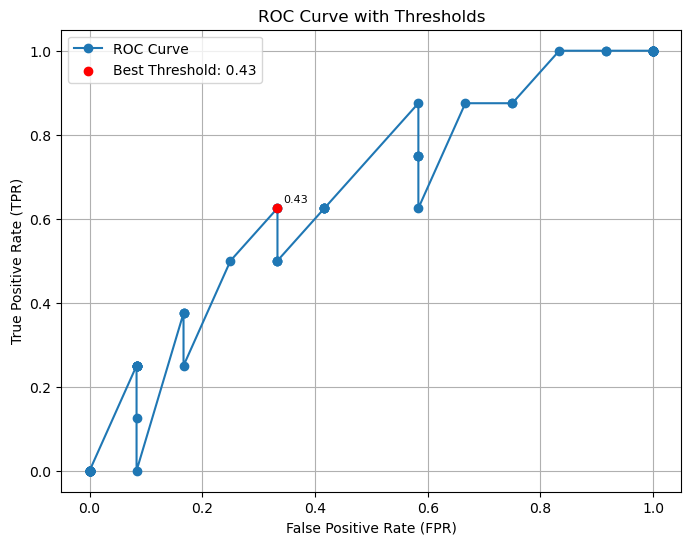

In [33]:
thresholds = np.linspace(0, 1, 100)
roc_points = compute_roc_points(perceptron, data, thresholds.tolist())
plot_roc_with_thresholds(roc_points)

100


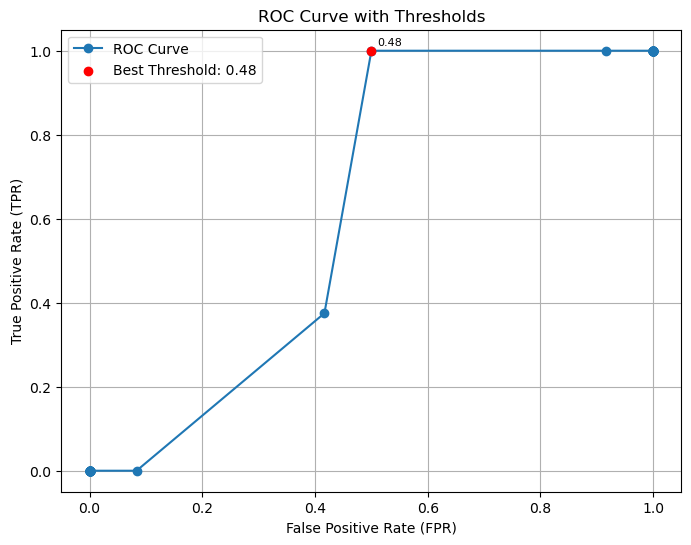

In [34]:
thresholds = np.linspace(0, 1, 100)
roc_points = compute_roc_points(multilayer, data, thresholds.tolist())
print(len(roc_points))
plot_roc_with_thresholds(roc_points)

## Auc Analysis

In [36]:
from sklearn.metrics import roc_auc_score

# Complete Data Set
y_true = [int(ob.values[0][0]) for ob in data]
y_scores = [perceptron(ob.features) for ob in data]
# print([(x,y) for x,y in zip(y_true, y_scores)])

perceptron_auc = roc_auc_score(y_true, y_scores)
print(f"Perceptron FUll Data AUC: {perceptron_auc:.4f}")

y_true = [int(ob.values[0][0]) for ob in data]
y_scores = [multilayer(ob.features) for ob in data]
# print([(x,y) for x,y in zip(y_true, y_scores)])

mlp_auc = roc_auc_score(y_true, y_scores)
print(f"MLP Full Data AUC: {mlp_auc:.4f}")

# Test Data Set
y_true = [int(ob.values[0][0]) for ob in test]
y_scores = [perceptron(ob.features) for ob in test]
# print([(x,y) for x,y in zip(y_true, y_scores)])

perceptron_auc = roc_auc_score(y_true, y_scores)
print(f"Perceptron Test Data AUC: {perceptron_auc:.4f}")

y_true = [int(ob.values[0][0]) for ob in test]
y_scores = [multilayer(ob.features) for ob in test]
# print([(x,y) for x,y in zip(y_true, y_scores)])

mlp_auc = roc_auc_score(y_true, y_scores)
print(f"MLP Test Data AUC: {mlp_auc:.4f}")


Perceptron FUll Data AUC: 0.6354
MLP Full Data AUC: 0.6250
Perceptron Test Data AUC: 0.4762
MLP Test Data AUC: 0.7619


In [10]:
# initialize a perceptron
# store weights after every cycle
import random
import matplotlib.pyplot as plt
import numpy as np
random.seed(12347)


def gradient_plot(training_data, ax, title):
    x = np.linspace(-1, 1, 1000)
    
    weights = []
    xs = []
    ys = []
    for _ in range(300):
        x_path =[]
        y_path = []
        perceptron = init_perceptron_model(2, include_bias=False)
        for _ in range(25):
            x_t, y_t = perceptron.weights
            x_path.append(x_t[0])
            y_path.append(y_t[0])
            online_perceptron(perceptron, training_data,1)
        xs.append(x_path)
        ys.append(y_path)
    
    cmap = plt.colormaps["plasma"]
    x_edges = np.linspace(-1.15,0.75,250)
    y_edges = np.linspace(-1,0.75,250)
    h, xedges, yedges = np.histogram2d(
        [x for x_path in xs for x in x_path],
        [y for y_path in ys for y in y_path],
        bins=(x_edges, y_edges)
    )
    pcm = ax.pcolormesh(xedges, yedges, h.T, cmap=cmap, rasterized=True)
    ax.set_xlabel("Weight 1")
    ax.set_ylabel("Weight 2")
    ax.set_title(title)

# Gradient Plots
The following charts show the paths that weights follow over the course of training. In each chart, 300 perceptrons are initialized with random weights and are then trained for 25 cycles on the actual training data and the testing data. The different plots reveal the different weight configurations that yield the lowest error for either set of data. 

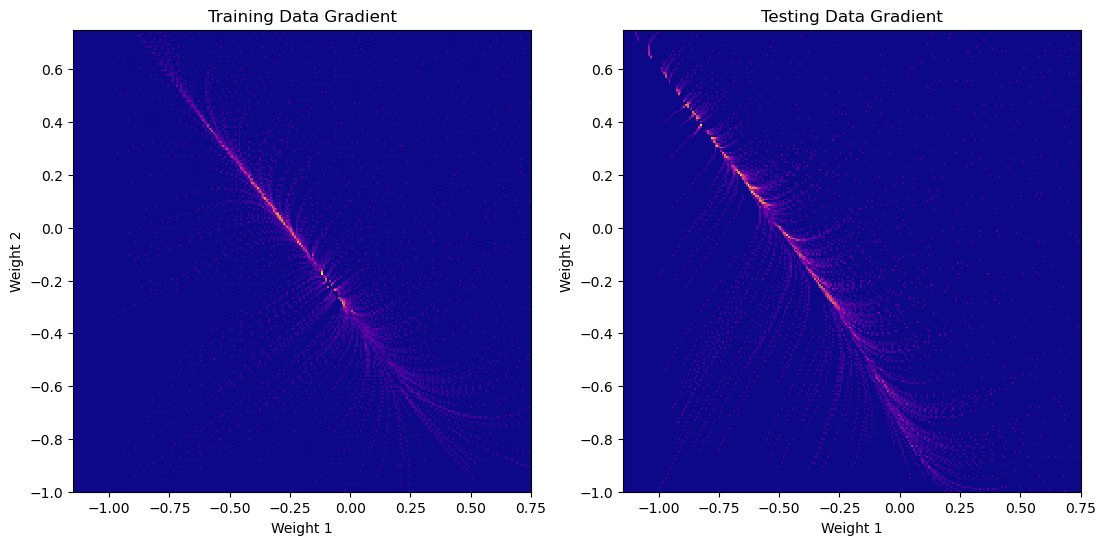

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,6))
gradient_plot(train, ax1, "Training Data Gradient")
gradient_plot(test, ax2, "Testing Data Gradient")
plt.show()